In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%b-%y')
dateparse2 = lambda x: datetime.strptime(x, '%y-%b')

In [73]:
train = pd.read_csv("train_classification.csv", parse_dates={'last_credit_pull_d2': ['last_credit_pull_d']}, date_parser=dateparse)
test = pd.read_csv("test_classification.csv", parse_dates={'last_credit_pull_d2': ['last_credit_pull_d']}, date_parser=dateparse2)


### Output Variable: 
`hi_int_prncp_pd`: binary indicator for whether a high percent of the loan repayments went to interest, rather than principal. Coded as an integer (0 = No, 1 = Yes). This is the target variable.


In [74]:
train.columns

Index(['last_credit_pull_d2', 'id', 'hi_int_prncp_pd', 'acc_now_delinq',
       'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type',
       'avg_cur_bal', 'bc_util', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'initial_list_status', 'int_rate', 'loan_amnt',
       'mort_acc', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
       'num_tl_30dpd', 'out_prncp_inv', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal',
       'total_rec_late_fee', 'verification_status'],
      dtype='object')

In [75]:
train.head()

,last_credit_pull_d2,id,hi_int_prncp_pd,acc_now_delinq,acc_open_past_24mths,addr_state,annual_inc,application_type,avg_cur_bal,bc_util,...,out_prncp_inv,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,tot_coll_amt,tot_cur_bal,total_rec_late_fee,verification_status
0,2017-02-01,3819,0,0,7,VA,36000.0,Individual,1987,53.6,...,0.00,0,0,debt_consolidation,D1,60 months,66,29807,0.0,Source Verified
1,2019-02-01,3820,0,0,2,WV,95000.0,Individual,7152,87.1,...,0.00,1,1,credit_card,D2,60 months,0,64366,0.0,Verified
2,2019-02-01,3821,1,0,2,IL,80000.0,Individual,15316,57.7,...,9099.27,0,0,debt_consolidation,C1,60 months,168,183792,0.0,Not Verified
3,2019-02-01,3822,0,0,2,CA,35000.0,Individual,7911,9.4,...,0.00,0,0,debt_consolidation,A2,36 months,0,31645,0.0,Source Verified
4,2017-06-01,3823,0,0,14,IL,63000.0,Individual,4717,70.3,...,0.00,0,0,debt_consolidation,E2,60 months,0,47171,0.0,Source Verified


In [76]:
#Check missing data: no missing data
train.isnull().sum()

last_credit_pull_d2     0
id                      0
hi_int_prncp_pd         0
acc_now_delinq          0
acc_open_past_24mths    0
addr_state              0
annual_inc              0
application_type        0
avg_cur_bal             0
bc_util                 0
delinq_2yrs             0
delinq_amnt             0
dti                     0
earliest_cr_line        0
emp_length              1
emp_title               0
grade                   0
home_ownership          0
initial_list_status     0
int_rate                0
loan_amnt               0
mort_acc                0
num_sats                0
num_tl_120dpd_2m        0
num_tl_90g_dpd_24m      0
num_tl_30dpd            0
out_prncp_inv           0
pub_rec                 0
pub_rec_bankruptcies    0
purpose                 0
sub_grade               0
term                    0
tot_coll_amt            0
tot_cur_bal             0
total_rec_late_fee      0
verification_status     0
dtype: int64

In [77]:
def transform(data):
    #cleaning term
    data['term'] = data['term'].str.replace('months', '')

    #cleaning emp_length
    #fill the only 1 na with 0 
    data['emp_length'] = data['emp_length'].str.replace('< 1 year', '0', regex=True)
    data['emp_length'] = data['emp_length'].str.replace('years', '', regex=True)
    data['emp_length'] = data['emp_length'].str.replace('year', '', regex=True)    
    data['emp_length'] = data['emp_length'].str.replace('+', '', regex=True)
    data['emp_length'] = data['emp_length'].str.replace(' ', '', regex=True)

    data['emp_length'] = data['emp_length'].fillna(0)
    
    data['emp_length'] = data['emp_length'].astype('int')

    ### binning employment title column '
    # count the value occurrences in column A
    value_counts = data['emp_title'].value_counts()
    # identify values with count <= 2
    values_to_change1 = value_counts[value_counts <= 2].index.tolist()
    # replace the identified values with a new value (e.g., -1)
    data.loc[data['emp_title'].isin(values_to_change1), 'emp_title'] = 'other1'
    
    values_to_change2 = value_counts[value_counts <= 5].index.tolist()
    data.loc[data['emp_title'].isin(values_to_change2), 'emp_title'] = 'other2'

transform(train)
transform(test)

0    3334
1    2444
Name: out_prncp_inv_categorical, dtype: int64

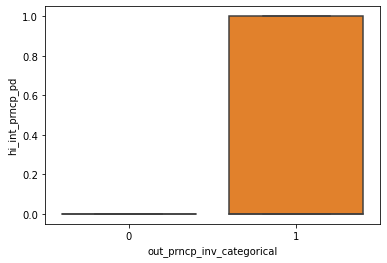

In [78]:
def out_prncp_tranform(data):
    data["out_prncp_inv_categorical"] = 0
    data.loc[data['out_prncp_inv']> 0, 'out_prncp_inv_categorical'] = 1

out_prncp_tranform(train)
out_prncp_tranform(test)

sns.boxplot(y = train['hi_int_prncp_pd'], x = train['out_prncp_inv_categorical'])
display(train.out_prncp_inv_categorical.value_counts())

In [79]:
import re

def monthly_payment(principle, rate, time):
    '''
    https://www.mymove.com/mortgage/mortgage-calculation/
    '''
    exponential_term = np.power(1 + rate, time)

    return principle * rate * exponential_term / (exponential_term - 1)

def remaining_time(monthly_payment, int_rate, out_prncp_inv):

    '''
    https://finance.zacks.com/figure-out-much-left-mortgage-9287.html
    :param monthly_payment:
    :param int_rate:
    :param out_prncp_inv:
    :return:
    '''

    return -np.log(1 - out_prncp_inv * int_rate / monthly_payment) / np.log(1 + int_rate)

def pipeline(df: pd.DataFrame):

    regex = re.compile("[\d]+")

    df['term in months'] = df['term'].apply(lambda x: int(regex.findall(x)[0]))
    df['monthly interest rate'] = df['int_rate'] / 100 / 12

    df['monthly_payment'] = df[['loan_amnt', 'monthly interest rate', 'term in months']].apply(
        lambda x: monthly_payment(x[0], x[1], x[2]), axis=1)

    df['paid_princp_inv'] = df['loan_amnt'] - df['out_prncp_inv']
    df['duration'] =  df[['monthly_payment', 'monthly interest rate', 'paid_princp_inv']].apply(
        lambda x: remaining_time(x[0], x[1], x[2]), axis=1)

    df['remaining time'] = df[['monthly_payment', 'monthly interest rate', 'out_prncp_inv']].apply(
        lambda x: remaining_time(x[0], x[1], x[2]), axis=1)

    # Simple will be paid
    df.loc[~np.isinf(df['remaining time']), 'will be paid'] = df.loc[~np.isinf(
        df['remaining time']), 'remaining time'] * df.loc[~np.isinf(
        df['remaining time']), 'monthly_payment']

    df['will be paid'].fillna(0, inplace=True)

    # adjusted with interest rate
    df['remaining time to end'] = df['term in months'] - df['duration']
    return df

train_feature = pipeline(train)
test_feature = pipeline(test)

# display(train_feature.shape)
# display(test_feature.shape)

## MODEL

In [80]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

X = train_feature[['out_prncp_inv', 'int_rate', 'monthly_payment', 'remaining time', 'remaining time to end']]
y = train_feature['hi_int_prncp_pd'].reset_index(drop=True)

poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
X = poly.fit_transform(X)
X = pd.DataFrame(data=X, columns = poly.get_feature_names_out())

X['out_prncp_inv_categorical'] = train_feature['out_prncp_inv_categorical']

In [81]:
#https://www.statsmodels.org/dev/discretemod.html

logit_model = sm.Logit(y, X).fit()
logit_model.summary()

prediction_train_feat = logit_model.predict(X) 

Optimization terminated successfully.
         Current function value: 0.196242
         Iterations 12


## PREDICTIONS

### Predict on Train Data

In [82]:
test_X = test_feature[['out_prncp_inv', 'int_rate', 'monthly_payment', 'remaining time', 'remaining time to end']]
poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
test_X = poly.fit_transform(test_X)
test_X = pd.DataFrame(data=test_X, columns = poly.get_feature_names_out())
test_X['out_prncp_inv_categorical'] = test_feature['out_prncp_inv_categorical']

test_X.head(2)

,out_prncp_inv,int_rate,monthly_payment,remaining time,remaining time to end,out_prncp_inv^2,out_prncp_inv int_rate,out_prncp_inv monthly_payment,out_prncp_inv remaining time,out_prncp_inv remaining time to end,...,monthly_payment^2 remaining time,monthly_payment^2 remaining time to end,monthly_payment remaining time^2,monthly_payment remaining time remaining time to end,monthly_payment remaining time to end^2,remaining time^3,remaining time^2 remaining time to end,remaining time remaining time to end^2,remaining time to end^3,out_prncp_inv_categorical
0,0.0,6.49,459.666772,-0.0,1.421085e-14,0.0,0.0,0.0,-0.0,0.0,...,-0.0,3.002662e-09,0.0,-0.0,9.282897e-26,-0.0,0.0,-0.0,2.869859e-42,0
1,0.0,5.32,210.803469,-0.0,0.000000e+00,0.0,0.0,0.0,-0.0,0.0,...,-0.0,0.000000e+00,0.0,-0.0,0.000000e+00,-0.0,0.0,-0.0,0.000000e+00,0


Train Classification accuracy = 92.3%
Train Classification Recall = 83.3%


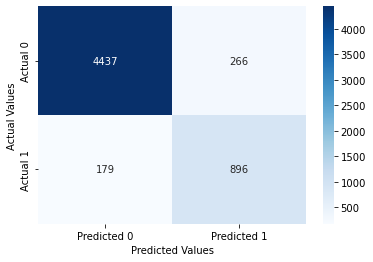

In [83]:
threshold = 0.39
def confusion_matrix_train(model,cutoff=threshold):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    recall = (cm[1,1] / (cm[1,1] + cm[1,0]))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Train Classification accuracy = {:.1%}".format(accuracy))
    print("Train Classification Recall = {:.1%}".format(recall))
    return accuracy, recall

train_accuracy, train_recall = confusion_matrix_train(logit_model)

#### Predict on Test Data

In [84]:
prediction_s_f = logit_model.predict(test_X)
prediction_s_f.shape

(3818,)

In [85]:
# prediction = pd.DataFrame(prediction_s, columns=['Predicted'])
prediction = pd.DataFrame(prediction_s_f, columns=['Category'])
prediction.index = test.id
prediction.index.name = 'id'

prediction.shape

(3818, 1)

In [86]:
#Change based on Threshold

prediction['Category'] = np.where(prediction["Category"]>= threshold, 1, 0)

In [87]:

prediction.to_csv(r'/Users/juliachu/Dropbox/Northwestern/2022-2023/2.WQ/STAT 303-2/kaggle/Loan_Amount/Logistic/prediction.csv', header=True, index=True)